# Performance benchmark

The aim of this notebook is to compare different elasticsearch settings in terms of performance and quality of results (closeness to ground truth).

## Variables to fine-tune
We establish the following values for different elasticsearch settings:

1. Number of shards: 1, 3, 6, 12
2. Max num segments: 1 (optimal for read-only indices)
3. Query: We take as base query the mediawiki query (most complete, slow), and perform the following modifications to it:
    * [`base`] No modification
    * [`no-rescoring`] Skip rescoring
    * [`no-plain`] Restrict to non-plain fields
    * [`restrict-4`] Restrict to title, text, opening_text and heading
    * [`restrict-2`] Restrict to title and text
   
   These modifications are independent (e.g. there is rescoring in `no-plain` and plain fields are used in `restrict-4`)

## Data

The data with which the benchmark will be carried out is composed of keywords in course descriptions, for which we know the relevant wikipage from manual tagging.

A random subset of keywords will be selected every time to prevent caching at both elasticsearch level and file system level.

## Procedure

For each setting (i.e. choice of (number_of_shards, query)), we will randomly select *n* keywords from the course descriptions, then run both a wikipedia api request and an elasticsearch request for each of them. We will keep track of the execution time and we will evaluate the quality of the results by checking whether the manually-tagged page associated to the keywords is contained in the list of results.

## Disclaimer

All requests will be directed to the graph-ai-test server, which runs elasticsearch on a regular HDD. Replacing that with an SDD would improve performance presumably 5 to 10-fold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unicodedata

from concept_detection.interfaces.es import ES
from concept_detection.interfaces.wp import WP
from concept_detection.interfaces.db import DB

from concept_detection.text.utils import normalize

from concept_detection.time.stopwatch import Stopwatch
from concept_detection.text.io import ProgressBar

from concept_detection.test.courses.compare import *

## Initialization

We instantiate the interfaces to communicate with the database and the wikipedia api.

In [3]:
db = DB()
wp = WP()

We define the grids of values for each variable and the interfaces to communicate with elasticsearch.

In [4]:
queries = ['base', 'no-rescoring', 'no-plain', 'restrict-4', 'restrict-2']

es = {1: ES('wikipages_1_shards'), 3: ES('wikipages_3_shards'), 6: ES('wikipages_6_shards'), 12: ES('wikipages')}
es = {1: ES('wikipages_1_shards'), 12: ES('wikipages')}
shards = list(es.keys())

We also set several constants that we will use later.

In [5]:
batch_size = 100    # number of keywords per setting
random_seed = 0     # seed for randomness

We finally initialize a variable to hold all results of the execution, so that we can analyze them later.

In [6]:
results = []

## Ground truth

We obtain the ground truth keywords to pages

In [7]:
wikified_course_descriptions = db.query_wikified_course_descriptions()
ground_truth = pd.DataFrame([(normalize(result.keywords), result.page_id, result.page_title) for course_id in wikified_course_descriptions for result in wikified_course_descriptions[course_id]], columns=['Keywords', 'PageID', 'PageTitle'])

ground_truth

,Keywords,PageID,PageTitle
0,architectural,12319895,Architectural_firm
1,architectural production,21296224,Architecture
2,architectural thinking,7217678,Enterprise_Architecture_Body_of_Knowledge
3,architecture,25596555,Lego_Architecture
4,casts,1006266,Plaster_cast
...,...,...,...
29162,voice,38481,Human_voice
29163,architectures,25652303,Computer_architecture
29164,distributed architectures,8501,Distributed_computing
29165,information systems,237495,Information_system


Also we need the ids of all pages in the database so we can filter them in the computation of the recall. Otherwise we might penalize elasticsearch for not finding pages **not present** in the database.

In [8]:
db_page_ids = db.get_wikipage_ids()

## Helper functions

The following function processes a batch of keywords in a given setting and returns a list of the results.

In [9]:
def es_search(query, shard):
    if query == 'base':
        return es[shard].search_mediawiki
    if query == 'no-rescoring':
        return es[shard].search_mediawiki_no_rescore
    if query == 'no-plain':
        return es[shard].search_mediawiki_no_plain
    if query == 'restrict-4':
        return es[shard].search_mediawiki_restrict_4
    if query == 'restrict-2':
        return es[shard].search_mediawiki_restrict_2

In [10]:
def process_batch(batch, query, shard):
    wp_time = 0
    es_time = 0
    sw = Stopwatch()
    
    es_wp_recalls = []
    es_gt_recalls = []
    wp_gt_recalls = []
    
    for index, row in batch.iterrows():
        keywords = row['Keywords']
        
        sw.reset()
        wp_results = wp.search(keywords)
        wp_time += sw.delta()
        
        sw.reset()
        es_results = es_search(query, shard)(keywords)
        es_time += sw.delta()
        
        wp_page_ids = set(r.page_id for r in wp_results if r.page_id in db_page_ids)
        es_page_ids = set(r.page_id for r in es_results)
        gt_page_ids = {row['PageID']}
        
        es_wp_recalls.append(len(es_page_ids & wp_page_ids) / len(wp_page_ids) if wp_page_ids else 1)
        es_gt_recalls.append(len(es_page_ids & gt_page_ids) / len(gt_page_ids) if gt_page_ids else 1)
        wp_gt_recalls.append(len(wp_page_ids & gt_page_ids) / len(gt_page_ids) if gt_page_ids else 1)
    
    wp_avg_time = wp_time / len(batch)
    es_avg_time = es_time / len(batch)
    
    es_wp_avg_recall = np.mean(es_wp_recalls)
    es_gt_avg_recall = np.mean(es_gt_recalls)
    wp_gt_avg_recall = np.mean(wp_gt_recalls)
    
    return [query, shard, wp_avg_time, es_avg_time, es_wp_avg_recall, es_gt_avg_recall, wp_gt_avg_recall]

In [11]:
pb = ProgressBar(len(queries) * len(shards))
for query in queries:
    for shard in shards:
        batch = ground_truth.sample(batch_size)
        batch_results = process_batch(batch, query, shard)
        results.append(batch_results)
        pb.update()

[##################################################] 100.00%


In [30]:
results_df = pd.DataFrame(results, columns=['query', 'shards', 'wp_avg_time', 'es_avg_time', 'es_wp_avg_recall', 'es_gt_avg_recall', 'wp_gt_avg_recall'])
results_df['method'] = results_df['shards'].map(str) + '-shds-' + results_df['query']

results_df

,query,shards,wp_avg_time,es_avg_time,es_wp_avg_recall,es_gt_avg_recall,wp_gt_avg_recall,method
0,base,1,0.364781,0.998781,0.535909,0.87,0.98,1-shds-base
1,base,12,0.370916,1.386954,0.506464,0.79,0.93,12-shds-base
2,no-rescoring,1,0.371827,0.600880,0.484988,0.85,0.97,1-shds-no-rescoring
3,no-rescoring,12,0.400434,0.539073,0.456468,0.83,0.97,12-shds-no-rescoring
4,no-plain,1,0.371747,0.594477,0.533956,0.80,0.93,1-shds-no-plain
5,no-plain,12,0.407254,0.680282,0.532984,0.86,0.98,12-shds-no-plain
6,restrict-4,1,0.361043,0.593935,0.518623,0.83,0.99,1-shds-restrict-4
7,restrict-4,12,0.372261,0.570499,0.477853,0.81,0.97,12-shds-restrict-4
8,restrict-2,1,0.366684,0.535000,0.531575,0.87,0.95,1-shds-restrict-2
9,restrict-2,12,0.372126,0.467211,0.511659,0.77,0.95,12-shds-restrict-2


Text(0.5, 1.0, 'Average time WP vs ES for each of the queries,\n with 100 keywords per setting')

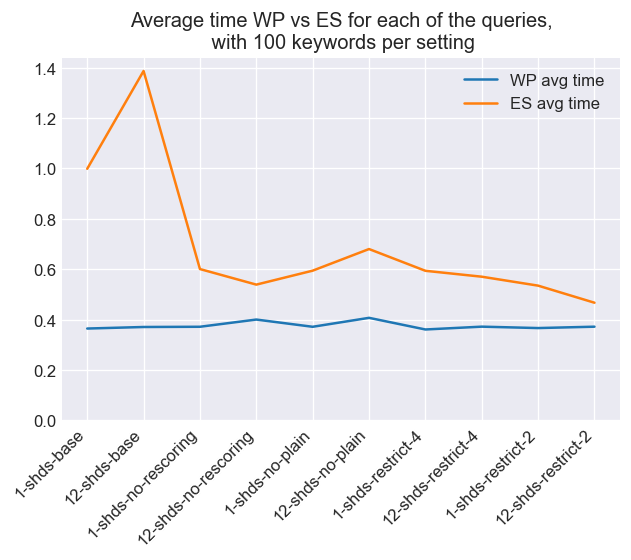

In [32]:
fig, ax = plt.subplots(dpi=120)

ax.plot(results_df['method'] + str(), results_df['wp_avg_time'], label='WP avg time')
ax.plot(results_df['method'], results_df['es_avg_time'], label='ES avg time')
plt.xticks(rotation=45, ha='right')

ax.set_ylim(0)
ax.legend()
ax.grid()
ax.set_title(f'Average time WP vs ES for each of the queries,\n with {batch_size} keywords per setting')

Text(0.5, 1.0, 'Average recall for each of the queries,\n with 100 keywords per setting')

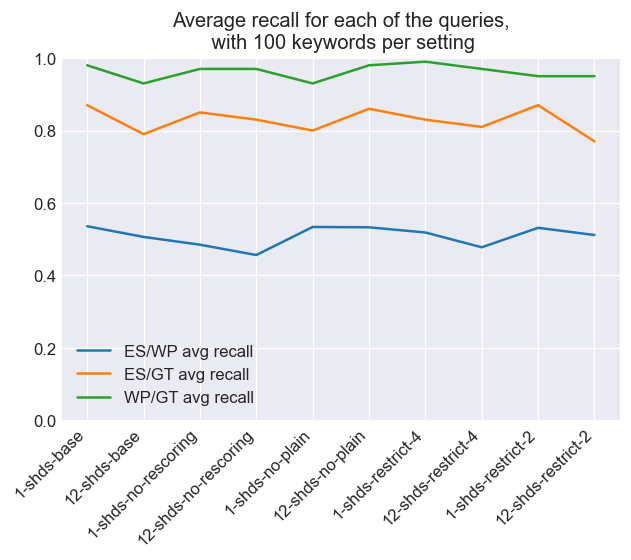

In [35]:
fig, ax = plt.subplots(dpi=120)

ax.plot(results_df['method'], results_df['es_wp_avg_recall'], label='ES/WP avg recall')
ax.plot(results_df['method'], results_df['es_gt_avg_recall'], label='ES/GT avg recall')
ax.plot(results_df['method'], results_df['wp_gt_avg_recall'], label='WP/GT avg recall')
plt.xticks(rotation=45, ha='right')

ax.set_ylim([0, 1])
ax.legend()
ax.grid()
ax.set_title(f'Average recall for each of the queries,\n with {batch_size} keywords per setting')